Learning Transformer

这个主要做当加入时间序列前后的图片，然后编码时间参数了之后的图像的恢复效果。
输入时 [batch_size, channel, Width, Height]

In [1]:
# --------------------------------------------------------------------
# Importing required libraries
# --------------------------------------------------------------------
import random
import numpy as np
import pandas as pd
import PIL.Image as Image
from glob import glob
from mymodels import VisionTransformer, ReconNet, VisionTransformerTimeSeries
from mymodels.unet import Unet
from mymodels.discriminatorv2 import Discriminator
import matplotlib.pyplot as plt
from myutils import imshow
from datetime import datetime


# importing pytorch functions
import torch
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tvtransforms
from torch.nn import SmoothL1Loss, BCELoss

# importing utils required in th code
from utils import subsample
from utils import transforms
from utils.evaluate import ssim, psnr, nmse
from utils.losses import SSIMLoss, SSIMLoss_V1
from osgeo import gdal
import torch.nn.functional as F

# Device
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cuda'
# np.random.seed(42)
# random.seed(42)

print("******* STARTED AT ************", datetime.now())

/home/snt/miniconda3/envs/causal_vit_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/snt/miniconda3/envs/causal_vit_env/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/snt/miniconda3/envs/causal_vit_env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


******* STARTED AT ************ 2025-01-02 22:42:21.049849


In [2]:
from typing import Any, Dict, Optional, Tuple, Union
from scipy.ndimage import gaussian_filter


def RealisticCloudMaskFunc(
    input: torch.tensor,
    seed: Optional[Union[int, Tuple[int, ...]]] = None,
    clouds_attributes: Optional[Dict[str, Any]] = None,
):

    clouds_attributes = clouds_attributes or {}
    scale = clouds_attributes.get(
        "scale", 2.0
    )  # Default to 1.0 if 'scale' is not provided
    threshold = clouds_attributes.get("threshold", 0.5)  # Default to 0.5
    blur = clouds_attributes.get("blur", 0.0)  # Default to 0.0
    cloud_size = clouds_attributes.get("cloud_size", 0.3)  # Default to 0.3
    cloud_count = clouds_attributes.get("cloud_count", 5)  # Default to 10

    if len(input.shape) != 3:
        raise ValueError("Shape should have 4 dimensions: [channels, height, width]")

    if seed is not None:
        np.random.seed(seed)

    channels, height, width = input.shape
    # Generate the base mask for a single spatial shape (height, width)
    mask = np.zeros((height, width), dtype=np.float32)

    for _ in range(cloud_count):
        center_x = np.random.randint(0, width)
        center_y = np.random.randint(0, height)

        cloud_width = int(width * cloud_size)
        cloud_height = int(height * cloud_size)

        noise = np.random.rand(cloud_height, cloud_width)
        smooth_noise = gaussian_filter(noise, sigma=scale)
        cloud = smooth_noise > threshold

        x_start = max(center_x - cloud_width // 2, 0)
        y_start = max(center_y - cloud_height // 2, 0)
        x_end = min(center_x + cloud_width // 2, width)
        y_end = min(center_y + cloud_height // 2, height)

        mask[y_start:y_end, x_start:x_end] = np.maximum(
            mask[y_start:y_end, x_start:x_end],
            cloud[: y_end - y_start, : x_end - x_start],
        )

    if blur > 0:
        mask = gaussian_filter(mask, sigma=blur) > 0.5

    mask = 1 - mask
    # Expand the mask to match the batch and channel dimensions
    mask_to_apply = np.tile(mask, (channels, 1, 1))

    # Convert mask to tensor
    mask_to_apply = torch.tensor(mask_to_apply, dtype=torch.float32)

    # Apply the mask to the input image (masking the input)
    masked_input = input * mask_to_apply

    return masked_input, torch.tensor(mask, dtype=torch.float32)

In [3]:
def transform_tensor_image(tensor_image, target_size=64 * 3, crop_size=60 * 3):
    _, h, w = tensor_image.shape

    tensor_image = F.interpolate(
        tensor_image.unsqueeze(0),
        size=(target_size, target_size),
        mode="bilinear",
        align_corners=False,
    ).squeeze(0)

    start_x = torch.randint(0, target_size - crop_size + 1, (1,)).item()
    start_y = torch.randint(0, target_size - crop_size + 1, (1,)).item()
    tensor_image = tensor_image[
        :, start_y : start_y + crop_size, start_x : start_x + crop_size
    ]

    if torch.rand(1).item() < 0.5:
        tensor_image = torch.flip(tensor_image, dims=[1])

    if torch.rand(1).item() < 0.5:
        tensor_image = torch.flip(tensor_image, dims=[2])

    return tensor_image  ## Fomated image tensor with size (C, H, W)


class ImagenetDataset(Dataset):
    def __init__(self, isval=False):

        if isval:
            ## combine paths of each imagenet validation image into a single list
            self.files = []
            pattern = "*.tif"
            for dir, _, _ in os.walk(
                "/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/data/intermediate/output_with_time_series/val"
            ):
                self.files.extend(glob(os.path.join(dir, pattern)))
        else:
            ## combine paths of each imagenet training image into a single list
            self.files = []  # get path of each imagenet images
            pattern = "*.tif"
            for dir, _, _ in os.walk(
                "/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/data/intermediate/output_with_time_series/train"
            ):
                self.files.extend(glob(os.path.join(dir, pattern)))

        self.transform = transform_tensor_image
        ################################################################

        self.factors = [2, 3, 4, 5, 6, 7, 8, 9, 10]

    def read_tiff(self, file_path):
        dataset = gdal.Open(file_path)
        if not dataset:
            raise FileNotFoundError(f"Unable to open the file: {file_path}")
        band_count = dataset.RasterCount
        bands_data = []
        for i in range(1, band_count + 1):
            band = dataset.GetRasterBand(i)  # 获取波段对象
            band_name = band.GetDescription()  # 获取波段的描述信息
            band_data = band.ReadAsArray()  # 读取波段数据为 NumPy 数组
            bands_data.append(band_data)

        image = np.stack(bands_data, axis=0)
        return image

    def get_mask_func(
        self,
        samp_style,
        factor,
    ):
        center_fractions = 0.08 * 4 / factor
        if samp_style == "random":
            mask_func = subsample.RandomMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        elif samp_style == "equidist":
            mask_func = subsample.EquispacedMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        return mask_func

    def add_gaussian_noise(self, x):
        ch, row, col = x.shape
        mean = 0
        var = 0.05
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (ch, row, col))
        gauss = gauss.reshape(ch, row, col)
        noisy = x + gauss
        return noisy.float()

    def __len__(
        self,
    ):
        return len(self.files)

    def __getitem__(self, idx):
        tiff = torch.from_numpy(self.read_tiff(self.files[idx]))
        tiff = self.transform(tiff)
        channels, height, width = tiff.shape
        time_span = int((channels - 1) / 11)
        images = np.split(tiff, [11 * (i + 1) for i in range(time_span)], axis=0)

        original_spaces_transformed = []
        masked_spaces = []
        cloud_masks = []
        added_cloud_masks = []
        for i in range(len(images) - 1):
            y = images[i]
            # Original image with cloud
            cloud_mask = torch.isnan(y).any(dim=0)
            cloud_mask = (~cloud_mask).int()
            y[:, cloud_mask == 0] = 0
            original_spaces_transformed.append(y.clone())
            masked_kspace = y.clone()

            if random.uniform(0, 1) < 0.5:
                y = torch.rot90(y, 1, [-2, -1])

            if random.uniform(0, 1) < 0.5:
                samp_style = "random"
            else:
                samp_style = "equidist"

            # factor = random.choice(self.factors)
            mask_func = self.get_mask_func(
                samp_style, factor=1.0
            )  # 我们可以随机选择需要的factor

            masked_kspace, _ = transforms.apply_mask(masked_kspace, mask_func)
            masked_kspace, added_cloud_mask = RealisticCloudMaskFunc(
                masked_kspace
            )  # 0 代表人工云在那，
            added_cloud_masks.append(added_cloud_mask.unsqueeze(0))
            masked_spaces.append(masked_kspace)
            cloud_masks.append(cloud_mask.unsqueeze(0))

        # masked_kspace = self.add_gaussian_noise(y)
        masked_space_concat = torch.cat(masked_spaces, dim=0)
        original_spaces_transformed_concat = torch.cat(
            original_spaces_transformed, dim=0
        )
        cloud_mask_concat = torch.cat(cloud_masks, dim=0)
        added_cloud_masks_concat = torch.cat(added_cloud_masks, dim=0)

        # 33*60*60, 33*60*60, 3*60*60, 3*60*60
        return (
            masked_space_concat,  # inputs
            original_spaces_transformed_concat,  # tragets
            cloud_mask_concat,
            added_cloud_masks_concat,
        )  # return iamge with masks, traget reference iamge, mask with cloud, mask with added cloud


train_dataset = ImagenetDataset()
val_dataset = ImagenetDataset(isval=True)
ntrain = 250
train_dataset, _ = torch.utils.data.random_split(
    train_dataset,
    [ntrain, len(train_dataset) - ntrain],
    generator=torch.Generator().manual_seed(42),
)


batch_size = 50
# epoch = 5
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=2,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)
valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=1,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)

Test the mask and future application

In [4]:
def read_tiff(file_path):
    dataset = gdal.Open(file_path)
    if not dataset:
        raise FileNotFoundError(f"Unable to open the file: {file_path}")
    band_count = dataset.RasterCount
    bands_data = []
    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription()
        band_data = band.ReadAsArray()
        bands_data.append(band_data)

    image = np.stack(bands_data, axis=0)
    return image


def create_time_series_pseudo_color_image(
    multi_channel_array, cloud_mask, added_cloud_mask
):
    if len(multi_channel_array.shape) != 3:
        raise ValueError("Input Array Shold be H W C")
    channel_list = [3, 2, 1]
    channels, h, w = multi_channel_array.shape
    time_span = int((channels - 1) / 11)
    images = np.split(
        multi_channel_array, [11 * (i + 1) for i in range(time_span)], axis=0
    )
    cloud_masks = np.split(cloud_mask, [i + 1 for i in range(time_span)], axis=0)
    added_cloud_masks = np.split(
        added_cloud_mask, [i + 1 for i in range(time_span)], axis=0
    )
    time_series_images = []
    background_cloud_images = []
    for i, image in enumerate(images):
        image = np.transpose(image, (1, 2, 0))
        pseudo_color_image = image[:, :, channel_list]
        time_series_images.append(pseudo_color_image)

        # nan_mask = np.isnan(pseudo_color_image).any(axis=-1)  # 掩码，标记 NaN 的位置

        background_cloud_image = np.full((h, w, 3), 0, dtype=np.uint8)  # ALL black
        background_cloud_image[cloud_masks[i].squeeze(0) == 1] = [
            255,
            255,
            255,
        ]  # Eecept mask white

        background_cloud_image[added_cloud_masks[i].squeeze(0) == 0] = [
            255,
            0,
            0,
        ]
        background_cloud_images.append(background_cloud_image)

    # pseudo_color_image[nan_mask] = [0, 0, 0]  # 将 NaN 对应像素设置为红色

    # # 归一化到 [0, 1] 范围，避免颜色失真
    # valid_mask = ~nan_mask  # 非 NaN 的有效像素
    # pseudo_color_image[valid_mask] -= pseudo_color_image[valid_mask].min()
    # pseudo_color_image[valid_mask] /= (
    #     pseudo_color_image[valid_mask].max() + 1e-6
    # )  # 防止除以 0

    return time_series_images, background_cloud_images


def test_image_transformation(dataset, idx):

    masked_kspace, original_image, cloud_mask, added_cloud_masks_concat = dataset[idx]
    time_series_images_original, background_cloud_images_original = (
        create_time_series_pseudo_color_image(
            original_image, cloud_mask, added_cloud_masks_concat
        )
    )
    time_series_images_masked, background_cloud_images_masked = (
        create_time_series_pseudo_color_image(
            masked_kspace, cloud_mask, added_cloud_masks_concat
        )
    )
    all_images = [
        time_series_images_original,
        background_cloud_images_original,
        time_series_images_masked,
        background_cloud_images_masked,
    ]

    fig, axes = plt.subplots(
        len(all_images), len(time_series_images_masked), figsize=(10, 10)
    )
    dict_name = {
        0: "Original",
        1: "Mask",
        2: "Masked",
        3: "Masked+Cloud",
    }
    for i, image_list in enumerate(all_images):
        for j in range(len(image_list)):
            axes[i][j].imshow(image_list[j])
            axes[i][j].axis("off")
            if j == 0:  # Add a title only to the first image of each row
                axes[i][j].set_title(dict_name[i + j])

    plt.tight_layout()
    plt.show()


idx = 110
test_image_transformation(train_dataset, idx)

IndexError: list index out of range

In [12]:
import torch
import torch.nn.functional as F


class MultiScaleLoss(torch.nn.Module):
    def __init__(self, scales=[1, 0.5, 0.25], weight_mse=1.0, weight_sam=1.0):
        """
        Multi-Scale Loss combining MSE and SAM.

        Args:
            scales (list): Downscaling factors for multi-scale loss.
            weight_mse (float): Weight for the MSE loss component.
            weight_sam (float): Weight for the SAM loss component.
        """
        super(MultiScaleLoss, self).__init__()
        self.scales = scales
        self.weight_mse = weight_mse
        self.weight_sam = weight_sam

    def forward(self, y_true, y_pred):
        """
        Compute the combined loss.

        Args:
            y_true (torch.Tensor): Ground truth tensor of shape (N, C, H, W).
            y_pred (torch.Tensor): Predicted tensor of shape (N, C, H, W).

        Returns:
            torch.Tensor: The combined loss.
        """
        total_loss = 0.0

        for scale in self.scales:
            if scale < 1:
                y_true_scaled = F.interpolate(
                    y_true, scale_factor=scale, mode="bilinear", align_corners=False
                )
                y_pred_scaled = F.interpolate(
                    y_pred, scale_factor=scale, mode="bilinear", align_corners=False
                )
            else:
                y_true_scaled = y_true
                y_pred_scaled = y_pred

            # MSE Loss
            mse_loss = F.mse_loss(y_pred_scaled, y_true_scaled)

            # SAM Loss
            sam_loss = self.sam_loss(y_true_scaled, y_pred_scaled)

            # Combine losses
            total_loss += self.weight_mse * mse_loss + self.weight_sam * sam_loss

        return total_loss

    @staticmethod
    def sam_loss(y_true, y_pred):
        """
        Spectral Angle Mapper (SAM) loss.

        Args:
            y_true (torch.Tensor): Ground truth tensor of shape (N, C, H, W).
            y_pred (torch.Tensor): Predicted tensor of shape (N, C, H, W).

        Returns:
            torch.Tensor: The SAM loss.
        """
        # Flatten spatial dimensions for vectorized computation
        y_true_flat = y_true.view(y_true.size(0), y_true.size(1), -1)  # (N, C, H*W)
        y_pred_flat = y_pred.view(y_pred.size(0), y_pred.size(1), -1)  # (N, C, H*W)

        # Compute dot product and norms
        dot_product = torch.sum(y_true_flat * y_pred_flat, dim=1)  # (N, H*W)
        norm_true = torch.norm(y_true_flat, dim=1) + 1e-8  # Avoid division by zero
        norm_pred = torch.norm(y_pred_flat, dim=1) + 1e-8

        # Compute SAM
        sam = torch.acos(
            torch.clamp(dot_product / (norm_true * norm_pred), -1.0, 1.0)
        )  # (N, H*W)
        return torch.mean(sam)  # Mean over all pixels

In [13]:
# --------------------------------------------------------------------
# Initialising Models
# --------------------------------------------------------------------

avrg_img_size = 180  # Don't change this
patch_size = 18  # 10
depth = 2
num_heads = 2
embed_dim = 12  # 64
time_span = 3
in_chans = 11 * time_span
epoch = 200
lr = 1e-4

net = VisionTransformerTimeSeries(
    avrg_img_size=avrg_img_size,
    patch_size=patch_size,
    in_chans=in_chans,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    is_LSA=False,  # ---------------Parameter for adding LSA component
    is_SPT=False,  # ---------------Parameter for adding SPT component
    rotary_position_emb=False,  # ---------------Parameter for adding ROPE component
    use_pos_embed=True,
    time_span=3,
)

model = ReconNet(net).to(device)

# Set biases to zero
for name, param in model.named_parameters():
    if name.endswith(".bias"):
        torch.nn.init.constant_(param, 0)
        param.requires_grad = False

print("#Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)


# --------------------------------------------------------------------
# Function to Save model
# --------------------------------------------------------------------
def save_model(path, model, train_hist, optimizer, scheduler=None):
    net = model.net
    if scheduler:
        checkpoint = {
            "model": ReconNet(net),
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
        }
    else:
        checkpoint = {
            "model": ReconNet(net),
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

    torch.save(train_hist, path + "train_hist.pt")
    torch.save(checkpoint, path + "checkpoint.pth")


"""Choose optimizer"""

criterion = SSIMLoss_V1(window_size=11, channel=1).to(device)
# criterion = ms_ssim().to(device)
# criterion = piq.ssim().to(device)
# criterion = MultiScaleLoss(scales=[1, 0.5, 0.25], weight_mse=1.0, weight_sam=1.0).to(
#     device
# )

optimizerG = optim.Adam(model.parameters(), lr=0.0)
train_hist = []
path = "./"  # Path for saving model checkpoint and loss history
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizerG,
    max_lr=lr,  # 1e-4
    total_steps=epoch,
    pct_start=0.1,
    anneal_strategy="linear",
    cycle_momentum=False,
    base_momentum=0.0,
    max_momentum=0.0,
    div_factor=0.1 * epoch,
    final_div_factor=9,
)


def check_nan_in_tensors(*tensors):
    for idx, tensor in enumerate(tensors):
        if torch.isnan(tensor).any():
            print(f"Tensor {idx} contains NaN values.")
            return True
    print("No NaN values found in the provided tensors.")
    return False

#Params: 207384
ReconNet(
  (net): VisionTransformerTimeSeries(
    (patch_embed): PatchEmbedTimeSerie(
      (proj): Conv2d(11, 24, kernel_size=(18, 18), stride=(18, 18))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
        (attn): MHSA_time_series(
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=24, out_features=384, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=128, out_features=24, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (drop_path): Identity()
        (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=24, out_features=96, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=96, out_features=24, bias=True)
          (drop): Dropout(p=0.0, inplace=Fa

Start to train the model

In [14]:
# --------------------------------------------------------------------
# Start to train the model
# --------------------------------------------------------------------

# ----------- discriminator parameters to test Adverserial loss addition to the network

run_only_last_time_loss = True
for epoch in range(0, epoch):  # loop over the dataset multiple times
    model.train()
    train_loss = 0.0
    time_span = model.net.patch_embed.time_span

    for i, data in enumerate(trainloader):
        inputs, targets, cloud_mask, added_cloud_mask = data
        channel_each = inputs.shape[1] // time_span
        last_time_start = channel_each * (time_span - 1)
        last_time_end = channel_each * time_span
        optimizerG.zero_grad()
        outputs = model(inputs.to(device))
        # Apply cloud_mask to outputs and targets
        expanded_cloud_mask = cloud_mask.repeat_interleave(
            model.net.in_chans // model.net.time_span, dim=1
        )  # 这里可疑
        masked_outputs = outputs * expanded_cloud_mask.to(device)
        masked_targets = targets.to(device) * expanded_cloud_mask.to(device)
        # masked_outputs = outputs
        # masked_targets = inputs

        # Normalize the masked regions to avoid scale bias 改一下，改成单独计算每个通道的Loss
        valid_pixels_total = cloud_mask.sum()
        valid_pixel_counts = cloud_mask.sum(dim=(0, 2, 3))
        max_valid_pixel_index = np.argmax(valid_pixel_counts)
        last_time_start = max_valid_pixel_index * 11
        last_time_end = last_time_start + 11
        if valid_pixels_total > 0:
            if run_only_last_time_loss:
                loss = criterion(
                    masked_outputs[:, last_time_start:last_time_end, :, :].to(device),
                    masked_targets[:, last_time_start:last_time_end, :, :].to(device),
                )
            else:
                loss = (
                    criterion(
                        masked_outputs.to(device),
                        masked_targets.to(device),
                    )
                    # / valid_pixels
                )
        else:
            loss = torch.tensor(0.0, device=device, requires_grad=True)
        # loss = criterion(
        #     outputs, targets.to(device), torch.tensor([1.0], device=device)
        # )
        # loss = criterion(outputs, targets.to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1, norm_type=1, error_if_nonfinite=True
        )
        optimizerG.step()

        train_loss += loss.item()

    # 在每个 epoch 结束时进行验证并可视化
    model.eval()
    with torch.no_grad():
        random_indices = random.sample(range(25, 30), 1)
        for i, (inputs, targets, cloud_mask, cloud_mask_added) in enumerate(valloader):
            if i in random_indices:  # 使用随机索引选择一些样本进行可视化
                # 获取模型输出
                outputs = model(inputs.to(device)).cpu()

                # 创建伪彩色图像
                input_images, _ = create_time_series_pseudo_color_image(
                    inputs[0, :, :, :].squeeze(0),
                    cloud_mask[0, :, :, :].squeeze(0),
                    cloud_mask_added[0, :, :, :].squeeze(0),
                )
                output_images, _ = create_time_series_pseudo_color_image(
                    outputs[0, :, :, :].squeeze(0),
                    cloud_mask[0, :, :, :].squeeze(0),
                    cloud_mask_added[0, :, :, :].squeeze(0),
                )
                targets_images, _ = create_time_series_pseudo_color_image(
                    targets[0, :, :, :].squeeze(0),
                    cloud_mask[0, :, :, :].squeeze(0),
                    cloud_mask_added[0, :, :, :].squeeze(0),
                )

                # 合并图像
                all_images = [
                    input_images,
                    output_images,
                    targets_images,
                ]

                # 绘制图像
                fig, axes = plt.subplots(
                    len(all_images), len(targets_images), figsize=(6, 6)
                )

                for i, image_list in enumerate(all_images):
                    for j in range(len(image_list)):
                        axes[i][j].imshow(image_list[j])
                        axes[i][j].axis("off")
                        # 可选：为每行图像设置标题
                        # if j == 0:
                        #     axes[i][j].set_title("Row Title")

                plt.tight_layout()
                plt.show()
                break  # 只显示一个 batch 的可视化

    scheduler.step()
    train_hist.append(train_loss / len(trainloader))
    save_model(path, model, train_hist, optimizerG, scheduler=scheduler)
    print("Epoch {}, Train loss.: {:0.4e}".format(epoch + 1, train_hist[-1]))

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=tuple, ), but expected one of:
 * (*, torch.dtype dtype = None)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


*********** Testing ************ 2024-12-30 18:21:33.883044


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.017798..0.4892971].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0196087..0.49624515].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0151094..0.46826604].


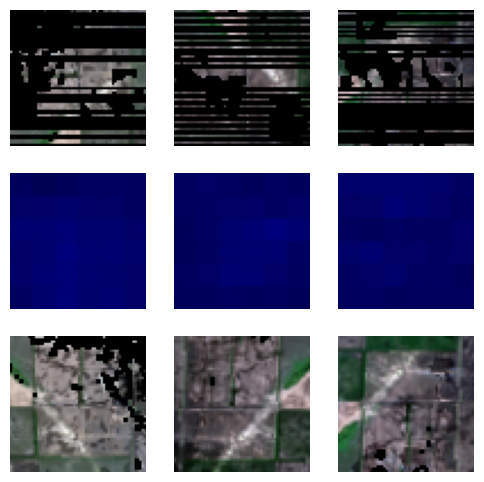

In [ ]:
# --------------------------------------------------------------------
# Test the model trained
print("*********** Testing ************", datetime.now())
# --------------------------------------------------------------------

"""Example reconstructions"""
valloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    generator=torch.Generator().manual_seed(1),
)
dataiter = iter(valloader)
model.eval()
maxval = torch.tensor([1.0], device="cpu")

ssim_clean = []
ssim_noise = []
psnr_clean = []
psnr_noise = []
nmse_clean = []
nmse_noise = []

random_indices = random.sample(range(25, 30), 1)

with torch.no_grad():
    for i, _ in enumerate(valloader):
        if i in random_indices:
            inputs, targets, cloud_mask, cloud_mask_added = next(dataiter)
            outputs = model(inputs.to(device)).cpu()
            # img_input = inputs_[0].numpy()

            input_images, _ = create_time_series_pseudo_color_image(
                inputs.squeeze(0), cloud_mask.squeeze(0), cloud_mask_added.squeeze(0)
            )

            output_images, _ = create_time_series_pseudo_color_image(
                outputs.squeeze(0), cloud_mask.squeeze(0), cloud_mask_added.squeeze(0)
            )

            targets_images, _ = create_time_series_pseudo_color_image(
                targets.squeeze(0), cloud_mask.squeeze(0), cloud_mask_added.squeeze(0)
            )

            all_images = [
                input_images,
                output_images,
                targets_images,
            ]

            fig, axes = plt.subplots(
                len(all_images), len(targets_images), figsize=(6, 6)
            )

            for i, image_list in enumerate(all_images):
                for j in range(len(image_list)):
                    axes[i][j].imshow(image_list[j])
                    axes[i][j].axis("off")
                    # if j == 0:  # Add a title only to the first image of each row
                    #     axes[i][j].set_title(title)

            # plt.tight_layout()
            # plt.show()
            # plt.axis("off")
            # plt.savefig("output/imagenet_after_spt" + ".png")

            # ssim_clean.append(ms_ssim(targets, outputs, maxval[0].item()))
            # ssim_noise.append(ms_ssim(targets, inputs_, maxval[0].item()))
            # psnr_clean.append(psnr(targets[0], outputs[0], maxval[0].item()))
            # psnr_noise.append(psnr(targets[0], inputs_[0], maxval[0].item()))
            # nmse_clean.append(
            #     nmse(
            #         targets[0],
            #         outputs[0],
            #     )
            # )
            # nmse_noise.append(nmse(targets, inputs_))

    # output_stat = pd.DataFrame()
    # output_stat["ssim_clean"] = ssim_clean
    # output_stat["ssim_noise"] = ssim_noise
    # # output_stat["psnr_clean"] = psnr_clean
    # # output_stat["psnr_noise"] = psnr_noise
    # # output_stat["nmse_clean"] = nmse_clean
    # # output_stat["nmse_noise"] = nmse_noise
    # output_stat.to_csv("output/breakdown.csv")
    # output_stat = output_stat.applymap(
    #     lambda x: x.item() if isinstance(x, torch.Tensor) else x
    # )

    # # output_stat = pd.read_csv("output/testing_metrics.csv")
    # testing_metrics = output_stat.mean(axis=0)
    # output_stat = pd.concat([output_stat, testing_metrics])
    # testing_metrics.to_csv("output/testing_metrics.csv")

    # print(" ssim:", testing_metrics["ssim_clean"])
    # print("*ssim:", testing_metrics["ssim_noise"])
    # print(" psnr:", testing_metrics["psnr_clean"])
    # print("*psnr:", testing_metrics["psnr_noise"])
    # print(" nmse:", testing_metrics["nmse_clean"])
    # print("*nmse:", testing_metrics["nmse_noise"])

# print("*********** ENDED AT ************", datetime.now())

# --------------------------------------------------------------------
# Completed running a ViT network with Imagenet dataset
# --------------------------------------------------------------------